# TransducedLM BPE-style FST bug

TransducedLM fails on FSTs where epsilon-input arcs produce all output and the non-epsilon input arc produces epsilon (BPE pattern).

In [15]:
%load_ext autoreload
%autoreload 2

https://github.com/timvieira/transduction/issues/4

In [16]:
from transduction.fst import FST, EPSILON
from transduction import Precover
from transduction.lm.ngram import CharNgramLM
from transduction.lm.transduced import TransducedLM

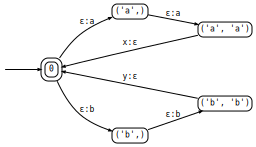

In [17]:
# BPE-style: eps:output chains, then source:eps back to start
fst = FST()
fst.add_start(0)
fst.add_stop(0)
fst.add_arc(0, EPSILON, 'a', ('a',))
fst.add_arc(('a',), EPSILON, 'a', ('a','a'))
fst.add_arc(('a','a'), 'x', EPSILON, 0)
fst.add_arc(0, EPSILON, 'b', ('b',))
fst.add_arc(('b',), EPSILON, 'b', ('b','b'))
fst.add_arc(('b','b'), 'y', EPSILON, 0)

fst

In [18]:
target = tuple(fst.transduce(list('xy')))
print('target:', target)  # ['a','a','b','b']

target: ('a', 'a', 'b', 'b')


In [19]:
assert fst.is_functional()[0]

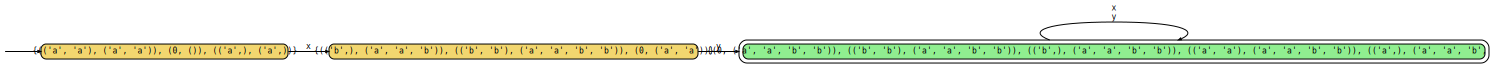

In [20]:
Precover(fst, target)

In [31]:
from transduction.lm.reference_transduced import ReferenceTransducedLM

In [32]:
inner_lm = CharNgramLM.train([list('xxyxy')] * 5, n=2, alpha=0.5)

In [40]:
tlm = TransducedLM(inner_lm, fst, max_beam=20)
ref_tlm = ReferenceTransducedLM(inner_lm, fst)

In [41]:
state = tlm.initial()
state

TransducedState(target=(), K=1)

In [42]:
ref_state = ref_tlm.initial()

In [48]:
# Step 1 works
#lp = state.logp_next['a']
#print(f'logp(a) = {lp}')
#state = state >> 'a'
#assert lp < 0

display_table([[ref_tlm.initial() >> 'a', tlm.initial() >> 'a']])

In [50]:
# Reference implementation: step through the target
state = tlm.initial()
for y in target:
    display(state)
    state = state >> y
display(state)

TransducedState(target=(), K=1)

TransducedState(target=('a',), K=1)

ValueError: Out of vocabulary: 'a'

In [51]:
# Reference implementation: step through the target
ref_state = ref_tlm.initial()
for y in target:
    display(ref_state)
    ref_state = ref_state >> y
display(ref_state)

Token,logp,p
'a',-0.7091,0.4921
'b',-1.0986,0.3333
'<EOS>',-1.7452,0.1746


Token,logp,p
'a',0.0000,1.0000
'<EOS>',-inf,0.0000


Token,logp,p
'b',-0.4520,0.6364
'a',-1.0986,0.3333
'<EOS>',-3.4965,0.0303


Token,logp,p
'b',0.0000,1.0000
'<EOS>',-inf,0.0000


Token,logp,p
'<EOS>',-0.7376,0.4783
'a',-0.7376,0.4783
'b',-3.1355,0.0435


In [29]:
# Step 2 fails: 'a' is not in logp_next
print(f'logp_next keys: {sorted(state.logp_next.keys())}')
assert 'a' in state.logp_next, (
    f"logp_next keys: {sorted(state.logp_next.keys())}"
)

logp_next keys: ['<EOS>']


AssertionError: logp_next keys: ['<EOS>']

In [30]:
# Side-by-side: Reference vs TransducedLM at each step
from transduction.viz import display_table

tlm_state = tlm.initial()
ref_state = ref_tlm.initial()

for i, y in enumerate(target):
    display_table([[ref_state, tlm_state]],
                  headings=['Reference', 'TransducedLM'])
    if y not in tlm_state.logp_next:
        print(f'Step {i}: TransducedLM missing {y!r} — bug confirmed')
        break
    ref_state = ref_state >> y
    tlm_state = tlm_state >> y

Step 1: TransducedLM missing 'a' — bug confirmed
